# Detección de Idiomas - LSTM

### Importar librerías

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

### Cargar el dataset

In [70]:
df = pd.read_csv("../dataset/updated_language_detection.csv")
df.describe()

,Text,Language
count,19821,19821
unique,19815,20
top,en cet article est partiellement ou en totalit...,Thai
freq,6,1000


### Preprocesar el Texto

- Tokenización: Convertir el texto en tokens (palabras).
- Padding: Asegurarse de que todas las secuencias de texto tengan la misma longitud.

In [71]:
# Unir todos los textos en una lista
texts = df['Text'].values

# Inicializar el Tokenizer para convertir texto en índices
maxlen=300
vocab_size = 200000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)

# Convertir los textos a secuencias de índices
X = tokenizer.texts_to_sequences(texts)

# Padding para asegurar que todas las secuencias tengan la misma longitud
X = pad_sequences(X, maxlen=maxlen)
X[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

### Codificar las Etiquetas

Codificamos las etiquetas (idiomas) en valores numéricos.

In [72]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Language'])
y[:5]

array([ 3, 15, 17, 16,  1])

### Dividir el dataset en conjuntos de entrenamiento y prueba

Se utiliza stratify para mantener la proporción de clases en los conjuntos de entrenamiento y prueba.

Train: 70%

Validation: 10%

Test: 20%

In [73]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['Language'])
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

print("Entrenamiento:", X_train.shape, y_train.shape)
print("Validación:", X_val.shape, y_val.shape)
print("Prueba:", X_test.shape, y_test.shape)

Entrenamiento: (13874, 300) (13874,)
Validación: (1982, 300) (1982,)
Prueba: (3965, 300) (3965,)


### Construcción del Modelo LSTM

Aquí creamos la arquitectura del modelo con una capa de Embedding, seguida de una capa LSTM y capas densas para la clasificación.

In [74]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100))
model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Entrenar el Modelo

In [75]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 119s 509ms/step - accuracy: 0.3810 - loss: 2.1634 - val_accuracy: 0.9647 - val_loss: 0.2191
Epoch 2/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 103s 477ms/step - accuracy: 0.9621 - loss: 0.1714 - val_accuracy: 0.9823 - val_loss: 0.0940
Epoch 3/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 100s 459ms/step - accuracy: 0.9917 - loss: 0.0446 - val_accuracy: 0.9818 - val_loss: 0.0826
Epoch 4/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 106s 490ms/step - accuracy: 0.9950 - loss: 0.0255 - val_accuracy: 0.9783 - val_loss: 0.0931
Epoch 5/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 140s 480ms/step - accuracy: 0.9973 - loss: 0.0156 - val_accuracy: 0.9839 - val_loss: 0.0743
Epoch 6/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 104s 477ms/step - accuracy: 0.9981 - loss: 0.0076 - val_accuracy: 0.9844 - val_loss: 0.0689
Epoch 7/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 105s 485ms/step - accuracy: 0.9992 - loss: 0.0054 - val_accuracy: 0.9849 - val_loss: 0.0768
Epoch 8/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 106s 489ms/step - accuracy: 0.9986 -

### Evaluación del Modelo

In [76]:
score, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Accuracy: {accuracy * 100:.2f}%')

124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.9882 - loss: 0.0457
Accuracy: 98.89%


### Guardar el modelo

In [77]:
model.save("../models/lstm_model.keras")

#### Precciones no acertadas

In [78]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
language_names = label_encoder.classes_
decoded_texts = tokenizer.sequences_to_texts(X_test)

test_indices = X_test.indices if hasattr(X_test, 'indices') else df.index[-len(X_test):]
incorrect_predictions = []

for i, test_index in enumerate(test_indices):
    if y_pred[i] != y_test[i]:
        predicted_language = language_names[y_pred[i]]
        real_language = language_names[y_test[i]]
        incorrect_predictions.append({
            "Id": test_index,
            "Texto": decoded_texts[i],
            "Predicción": predicted_language,
            "Idioma Real": real_language
        })
        print(f"Id: {i} - Texto: {decoded_texts[i]} - Predicción: {predicted_language} - Idioma Real: {real_language}")

df = pd.DataFrame(incorrect_predictions)
df.to_csv('../results/lstm_incorrect_predictions.csv', index=False, encoding='utf-8')

124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step
Id: 137 - Texto: iv peatükis esitatakse teiste parteide suhtes rakendatava taktika põhimõtted programm lõpeb hüüdlausega - Predicción: Thai - Idioma Real: Estonian
Id: 175 - Texto: структурированные пористые композиционные материалы из крупнозернистых частиц карбида вольфрама wc покрытых упругопластическими прослойками порошковая металлургия республиканский межведомственный сборник научных трудов белоруссия № - Predicción: Thai - Idioma Real: Russian
Id: 241 - Texto: แม้ประธานาธิบดีอับราฮัม ลินคอล์น ได้ประณาม จอห์น บราวน์ ว่าเป็น แต่นายบราวน์ได้รับการขนานนามเป็นหนึ่งใน ความพยายามของเขาที่จะสร้างขบวนการปลดแอกทาสแอฟริกันในปี ที่ ฮาร์เปอร์ เฟอรรี่ รัฐเวอร์จิเนีย ทำให้คนทั้งประเทศอเมริกาในขณะนั้นตะลึง เขาถูกนำไปขึ้นศาลด้วยข้อหากระทำการกบฏต่อรัฐ เวอร์จิเนีย กระทำการฆาตกรรมชาวใต้ คนที่เห็นด้วยกับการมีทาส และกระทำการปลุกระดมให้เหล่าทาสกบฏแข็งข้อ และในท้ายที่สุด เขาถูกตัดสินโทษด้วยการแขวนคอ โดยที่กลุ่มชาวใต้ของอเมริกาซึ่งสนับสนุนการมีทาสอ้างว่า การกบฏข

In [79]:
language_names = label_encoder.classes_
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=language_names))


Classification Report:
               precision    recall  f1-score   support

      Arabic       1.00      0.99      0.99       199
       Dutch       0.99      0.99      0.99       199
     English       0.97      0.99      0.98       200
    Estonian       1.00      0.96      0.98       200
      French       0.98      0.99      0.99       198
       Hindi       1.00      1.00      1.00       197
  Indonesian       0.99      0.99      0.99       194
      Korean       0.98      0.99      0.99       200
       Latin       0.97      0.98      0.98       190
     Persian       1.00      0.99      1.00       200
   Portugese       0.99      0.99      0.99       199
      Pushto       1.00      0.99      0.99       197
    Romanian       0.98      1.00      0.99       200
     Russian       0.99      0.98      0.99       200
     Spanish       1.00      0.99      1.00       199
     Swedish       1.00      0.99      1.00       197
       Tamil       0.98      1.00      0.99       196
  

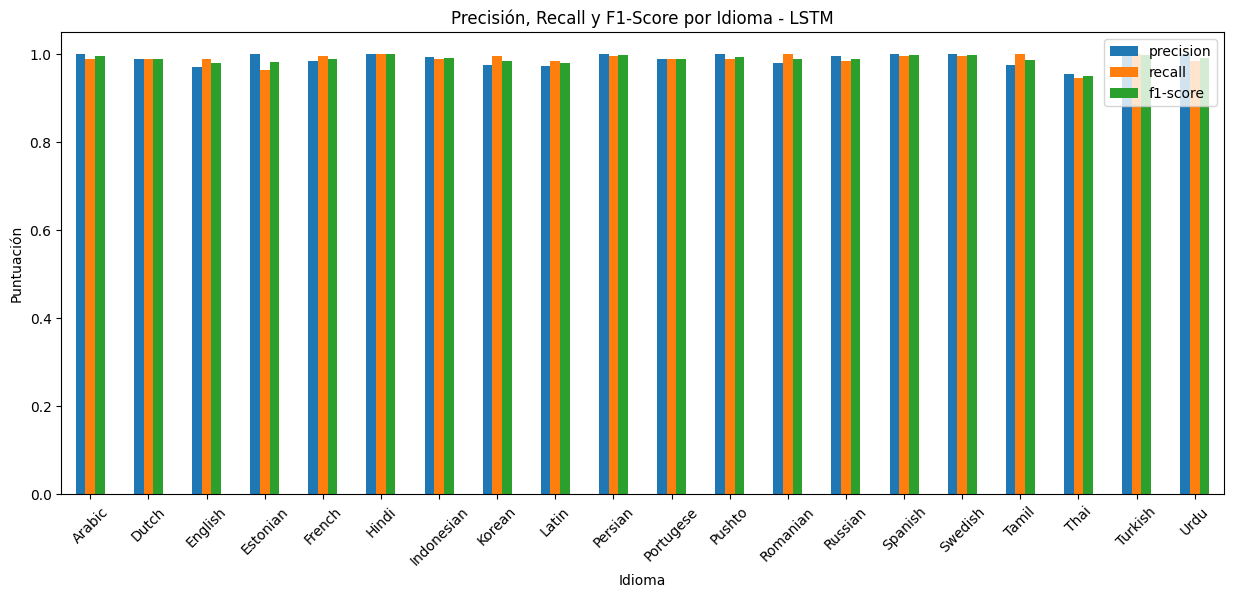

In [80]:
report_dict = classification_report(y_test, y_pred, target_names=language_names, output_dict=True)
report_df = pd.DataFrame(report_dict).T[:-3]

report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(15, 6))
plt.title("Precisión, Recall y F1-Score por Idioma - LSTM")
plt.ylabel("Puntuación")
plt.xlabel("Idioma")
plt.xticks(rotation=45)
plt.savefig("../plots/lstm_precision_recall_f1.png")
plt.show()

In [81]:
def preprocess_text(texts, tokenizer, max_len=100):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    return padded_sequences

input_text = ["hola este es un texto en español", "hello this is a text in english", "bonjour ceci est un texte en français", "ola isto é um texto em português"]
preprocessed_text = preprocess_text(input_text, tokenizer)

prediction = model.predict(preprocessed_text)
y_prediction = np.argmax(prediction, axis=1)

for i in range(len(input_text)):
    predicted_language = language_names[y_prediction[i]]
    print(f"Texto: {input_text[i]}")
    print(f"Predicción: {predicted_language}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
Texto: hola este es un texto en español
Predicción: Spanish

Texto: hello this is a text in english
Predicción: English

Texto: bonjour ceci est un texte en français
Predicción: French

Texto: ola isto é um texto em português
Predicción: Portugese



#### Matriz de Confusión

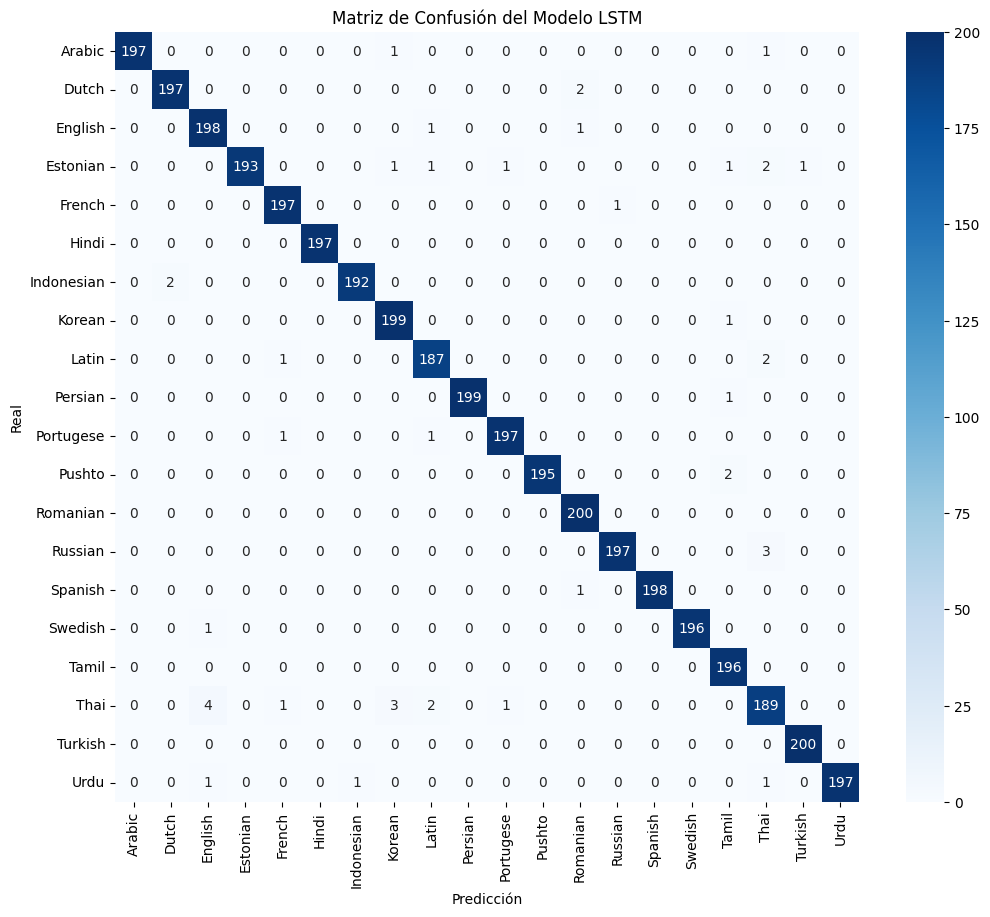

In [82]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=language_names, yticklabels=language_names)
plt.title("Matriz de Confusión del Modelo LSTM")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.savefig("../plots/lstm_confusion_matrix.png")
plt.show()

### Matriz de Confusión Normalizada

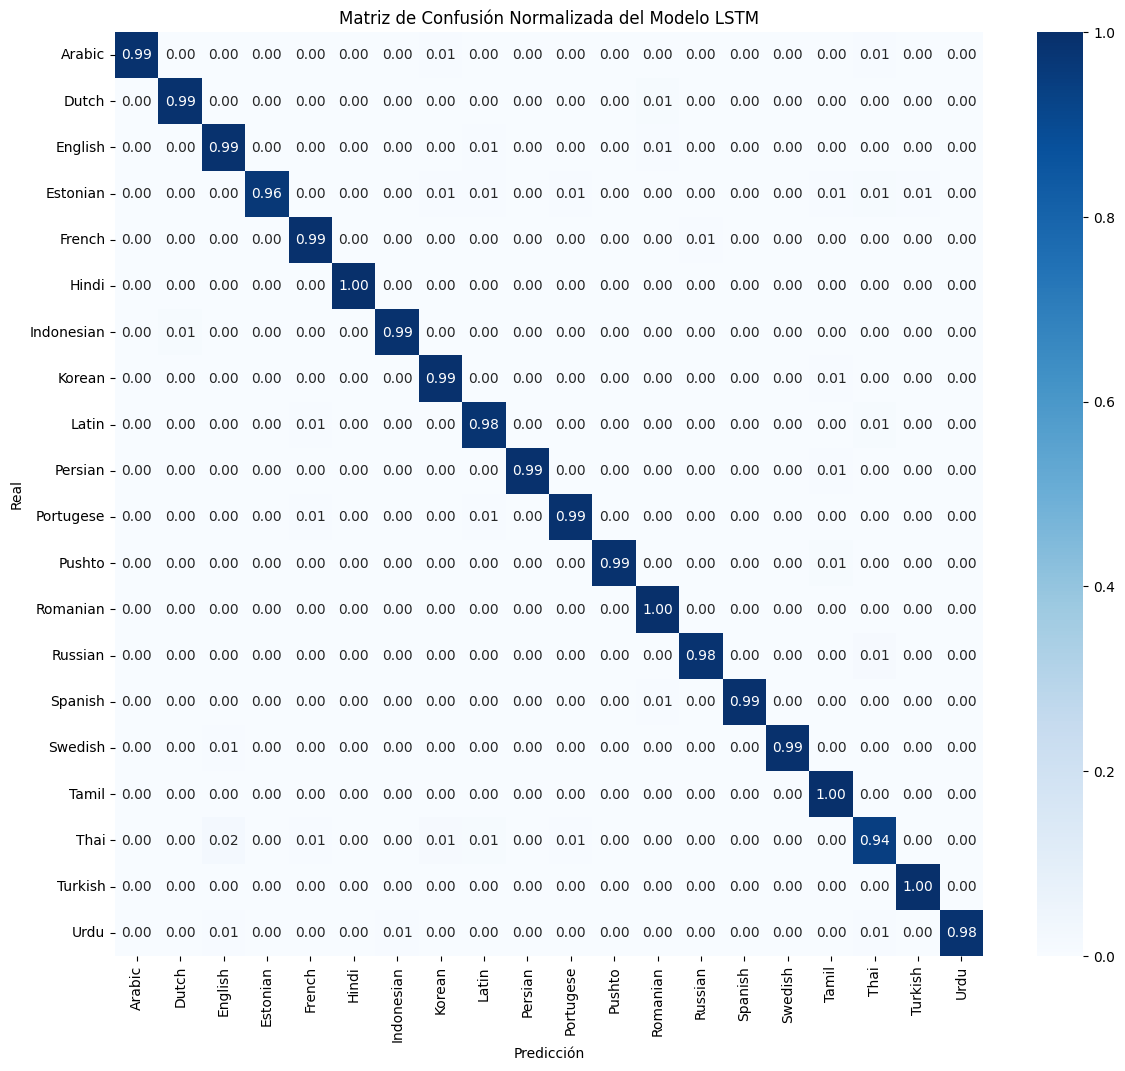

In [83]:
cm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=language_names, yticklabels=language_names)
plt.title("Matriz de Confusión Normalizada del Modelo LSTM")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.savefig("../plots/lstm_confusion_matrix_normalized.png")
plt.show()

### Accuracy en Train y Validation

FileNotFoundError: [Errno 2] No such file or directory: '/home/bauti/Documents/Facultad/4°/ia2-language-detection/notebooks/plots/lstm_accuracy_curve.png'

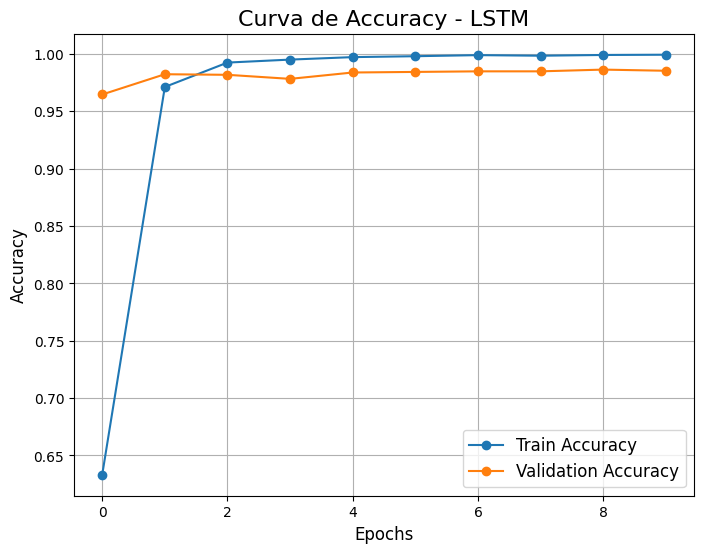

In [84]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(train_accuracy, label='Train Accuracy', marker='o')
plt.plot(val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Curva de Accuracy - LSTM', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig("plots/lstm_accuracy_curve.png")
plt.show()

### Loss en Train y Validation

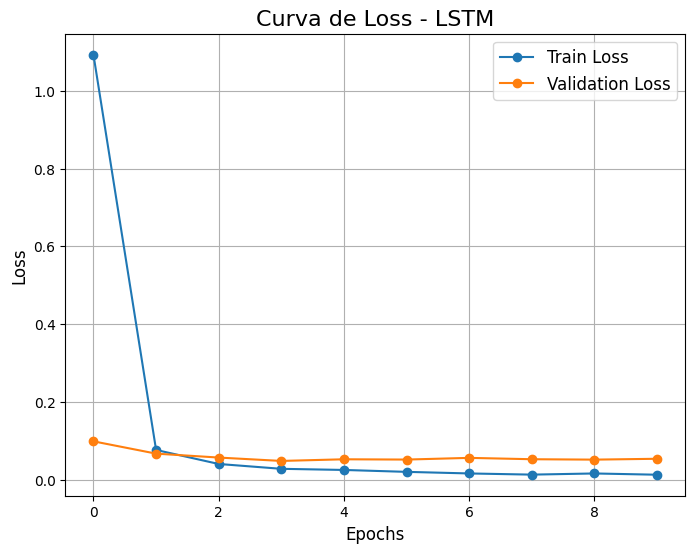

In [25]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Train Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Curva de Loss - LSTM', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig("plots/lstm_loss_curve.png")
plt.show()